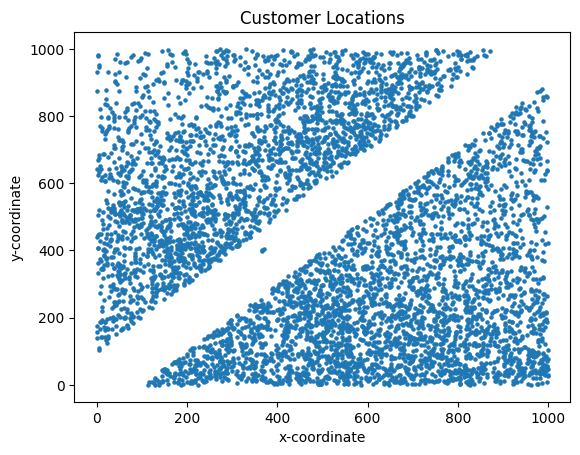

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('datasets/drone_cust_locations.csv', sep=';').drop('clientid', axis=1)

X = df['x']
y = df['y']

plt.scatter(X, y, s=5)
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Customer Locations')
plt.show()


In [18]:
from sklearn.cluster import KMeans

model = KMeans(init='random', n_clusters=3, random_state=42)
model.fit(df)

model.cluster_centers_

array([[702.08109226, 211.2703835 ],
       [198.44098904, 383.25861847],
       [548.20586479, 787.2788963 ]])